In [45]:
import pandas as pd
import yfinance as yf

# Download historical stock data
tckr = str(input("Enter your Ticker: "))
tckr = tckr.upper()
df = yf.download(tckr, start='2020-01-01', end='2025-12-31')

# Keep only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [46]:
# Predict the next day's closing price
df['Next_High'] = df['High'].shift(-1).fillna(df['Close'])

# Define features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_High']

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build a simple feedforward neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

c:\Users\genas\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
# Early stopping to prevent overfitting
# ReduceLROnPlateau to adapt the learning rate dynamically
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 132.5571 - val_loss: 133.5977 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.4980 - val_loss: 36.0751 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2484 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4978 - val_loss: 0.0839 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1984 - val_loss: 0.0622 - learning_rate: 0.0010
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1859 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2046 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1854 - val_loss: 0.0592 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1541 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 10/200

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# R² compares your model to a baseline model that always predicts the mean.
# If R² is close to 1, your model is capturing most of the trend in the data.
# If R² is 0, your model is no better than guessing the average.
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")  # Target: > 0.75



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
R² Score: 0.9720


In [57]:
y_test

Date
2024-04-30    15.029956
2024-05-01    14.605687
2024-05-02    14.831362
2024-05-03    14.862956
2024-05-06    14.957740
                ...    
2025-05-23    10.580000
2025-05-27    10.600000
2025-05-28    10.520000
2025-05-29    10.505000
2025-05-30    10.360000
Name: Next_High, Length: 272, dtype: float64

In [53]:
y_pred

array([15.067852 , 14.8912945, 14.6928005, 14.8026285, 14.953941 ,
       14.888558 , 14.523602 , 14.4743805, 14.561515 , 14.588156 ,
       14.711369 , 14.878327 , 14.869843 , 14.962277 , 14.857018 ,
       14.782928 , 14.74829  , 14.627654 , 14.711463 , 14.650126 ,
       14.287158 , 14.403025 , 14.439703 , 14.566782 , 14.464222 ,
       14.196733 , 14.000599 , 13.730562 , 13.70446  , 13.586191 ,
       13.861803 , 13.880358 , 13.491165 , 13.528578 , 13.733984 ,
       13.573418 , 13.645089 , 13.595202 , 13.436512 , 13.382339 ,
       13.501147 , 13.816959 , 13.7927475, 13.655209 , 13.580986 ,
       13.495132 , 13.457592 , 13.322104 , 13.3497505, 13.526773 ,
       13.632528 , 13.766043 , 13.969379 , 14.110607 , 13.9226055,
       13.658527 , 13.886869 , 13.990585 , 13.735095 , 13.551596 ,
       13.830802 , 14.043211 , 14.16655  , 14.073145 , 14.107058 ,
       13.36287  , 12.715286 , 12.860576 , 12.887211 , 12.981939 ,
       12.956015 , 12.981961 , 12.885519 , 12.921795 , 13.2712

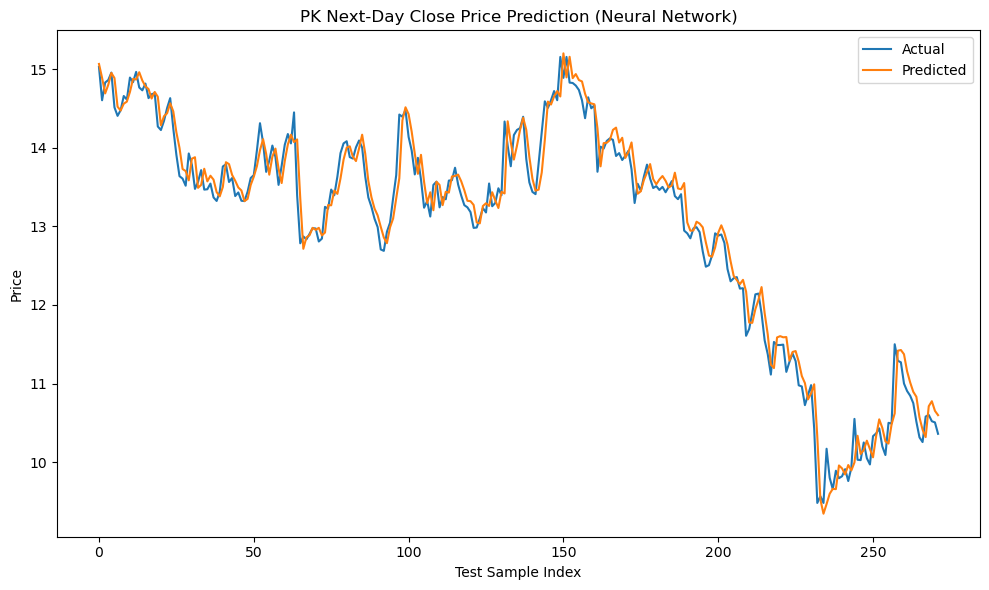

In [54]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.values, label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted')
plt.title(f'{tckr} Next-Day Close Price Prediction (Neural Network)')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()